# Handwritten digits

This merges tutorials from:
- https://rockpool.ai/basics/hello_MNIST.html
- https://www.tensorflow.org/quantum/tutorials/mnist

and adds a comparison between the performance of the neuromorphic, classica, and the quantum mode.

## Due to the "peculiarities" of tensorflow-quantum, you will need to run this tutorial in colab.
Run the next cell on your local machine at your own risk. The package installation cells are designed to run on colab.

The reason is that tensorflow-quantum requires python 3.9 and it also requires tensorflow version 2.15.0, and having this running simultaneously on a local machine turned out to be a nightmare.
Even on colab, it requires rewriting the python version used by colab (3.10) with 3.9.
For the record, locally I am not able to get it running either :)

The gist of this is: run this on colab, or you are on your own debugging the installation :)


In [2]:
######## QUANTUM

!sudo apt-get update -y
# select python version
!sudo update-alternatives --config python3
# check python version
!python --version
# install pip for new python
!sudo apt-get install python3.8-distutils
!wget https://bootstrap.pypa.io/get-pip.py
!python get-pip.py
# upgrade pip
!sudo apt install python3-pip
!python -m pip install --upgrade pip
#install tensorflow & tensorflow-quantum

!wget https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py -O /usr/local/lib/python3.10/dist-packages/google/protobuf/internal/builder.py
!pip install tensorflow==2.15.0 tensorflow-quantum google-auth-oauthlib tf-keras

############## NEUROMORPHIC
!pip install torch torchvision
!pip install rockpool tonic tqdm


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,085 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,858 kB]
Get:13 https://developer.download.nvidi

# Neuromorphic

In [4]:
import torch
import torchvision


In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [9.6, 3.6]
plt.rcParams['font.size'] = 12

from tqdm.autonotebook import tqdm, trange

from IPython.display import Image

# Leaky integrate-and-fire

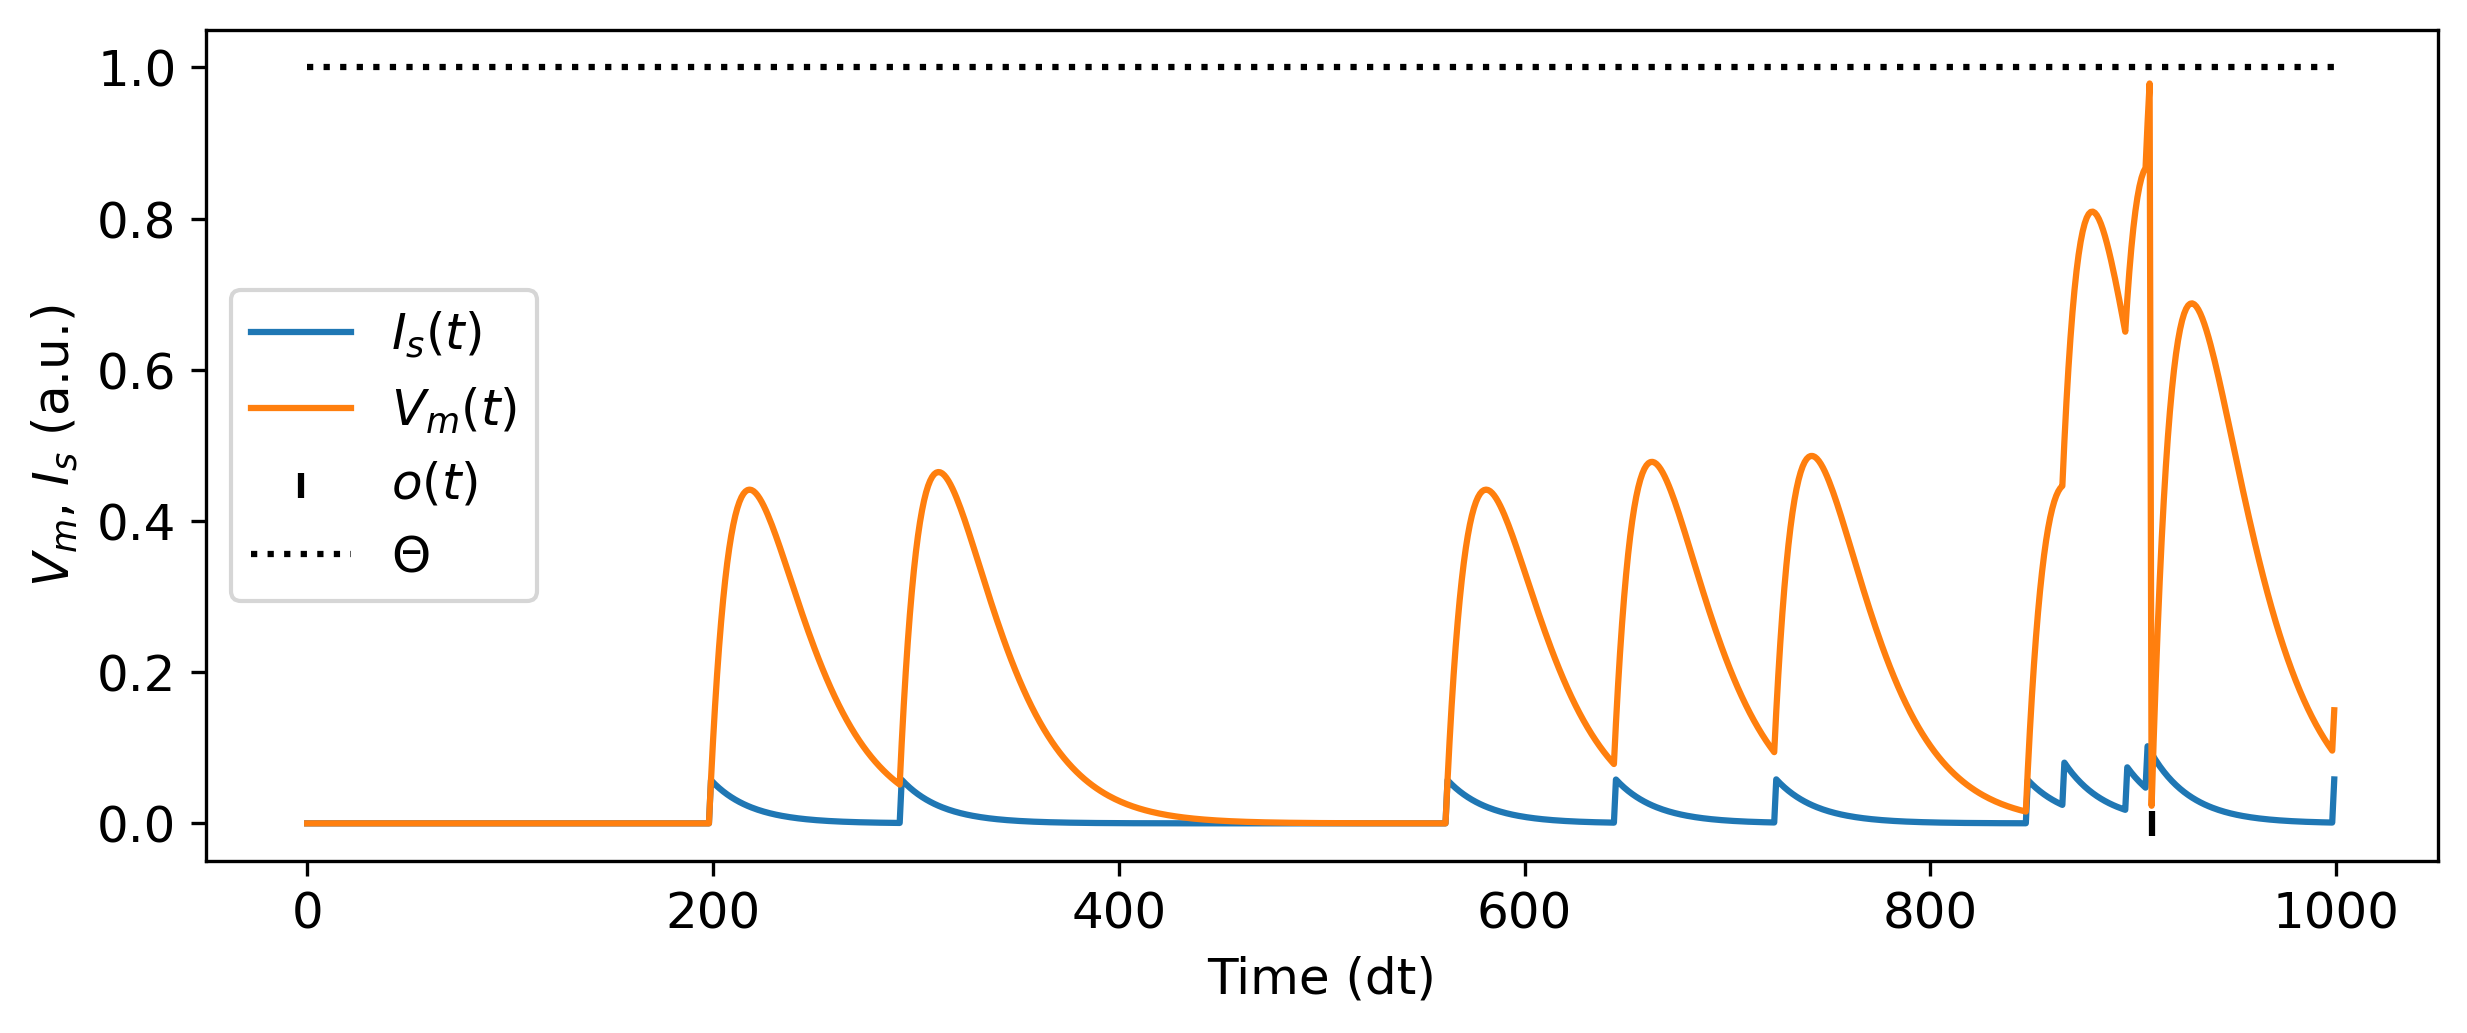

In [7]:
# - Import the SNN modules from rockpool
from rockpool.nn.modules import LIF
import numpy as np
# - Generate a spiking neuron
neuron = LIF(1)

# - Simulate this neuron for 1 sec with poisson spiking input z(t)
num_timesteps = int(1/neuron.dt)
input_z = 0.06 * (np.random.rand(num_timesteps) < 0.0125)
output, _, rec_dict = neuron(input_z, record = True)

# - Display the input, internal state and output events
plt.figure()
plt.plot(rec_dict['isyn'].squeeze(), label = '$I_s(t)$')
plt.plot(rec_dict['vmem'].squeeze(), label = '$V_m(t)$')
b, t, n = np.nonzero(output)
plt.scatter(t, n, marker='|', c = 'k', label = '$o(t)$')
plt.plot([0, num_timesteps], [neuron.threshold] * 2, 'k:', label='$\Theta$')
plt.xlabel('Time (dt)')
plt.ylabel('$V_m$, $I_s$ (a.u.)')
plt.legend();


# Again, load MNIST

But now we need also to encode the data in a SNN-compliant way


In [8]:
# - Number of samples per batch
batch_size = 256

# - Download and access the MNIST training dataset
train_data = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
test_data = torchvision.datasets.MNIST(
    root=".",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
evens = list(range(0, len(train_data), 100))
evenst = list(range(0, len(test_data), 100))
# - Create a data loader for the training dataset
train_subdata = torch.utils.data.Subset(train_data, evens)
test_subdata = torch.utils.data.Subset(test_data, evens)

train_loader = torch.utils.data.DataLoader(
    train_subdata,
    batch_size=batch_size, shuffle=True
)

# - Create a test dataset
test_loader = torch.utils.data.DataLoader(
    test_subdata,
    batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=torchvision.transforms.ToTensor(),
    ),
    batch_size=batch_size,
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 33604735.25it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1090104.60it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9652164.09it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6960368.57it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Now we need to decide how to encode the data samples for the SNN. The MNIST samples are resolution images, with no temporal component. We will encode the images by arranging the pixels into a 784-element vector, and creating 784 spiking input channels. We’ll use a Poisson process to generate an average input rate for each channel, according to the intensity of the corresponding pixel. Pixels with value 0 will have generate no input events; pixels with value 1 will generate the highest rate of events. To do so we need to define how many time-steps each sample will take, and what the duration of a single time-step will be.

In [9]:
# - Define the temporal aspects of a data sample
num_timesteps = 100
dt = 10e-3

# - Extract the number of classes and input channels
num_classes = len(torchvision.datasets.MNIST.classes)
input_channels = train_data[0][0].numel()

# - Define a function to encode an input into a poisson event series
def encode_poisson(data: torch.Tensor, num_timesteps: int, scale: float = 0.1) -> torch.Tensor:
  num_batches, frame_x, frame_y = data.shape
  data = scale * data.view((num_batches, 1, -1)).repeat((1, num_timesteps, 1))
  return (torch.rand(data.shape) < (data * scale)).float()

We also need to determine what the target output of the network will look like. The MNIST dataset has 10 classes. We’ll build a network with 10 output neurons, one for each class, and train the network to produce a high event rate for the target class and no events for the non-target classes. Our target will also be a time series of events, with the same duration as the input time series, and with 10 channels.

In [10]:
# - Define a function to encode the network target
def encode_class(class_idx: torch.Tensor, num_classes: int, num_timesteps: int) -> torch.Tensor:
  num_batches = class_idx.numel()
  target = torch.nn.functional.one_hot(class_idx, num_classes = num_classes)
  return target.view((num_batches, 1, -1)).repeat((1, num_timesteps, 1)).float()


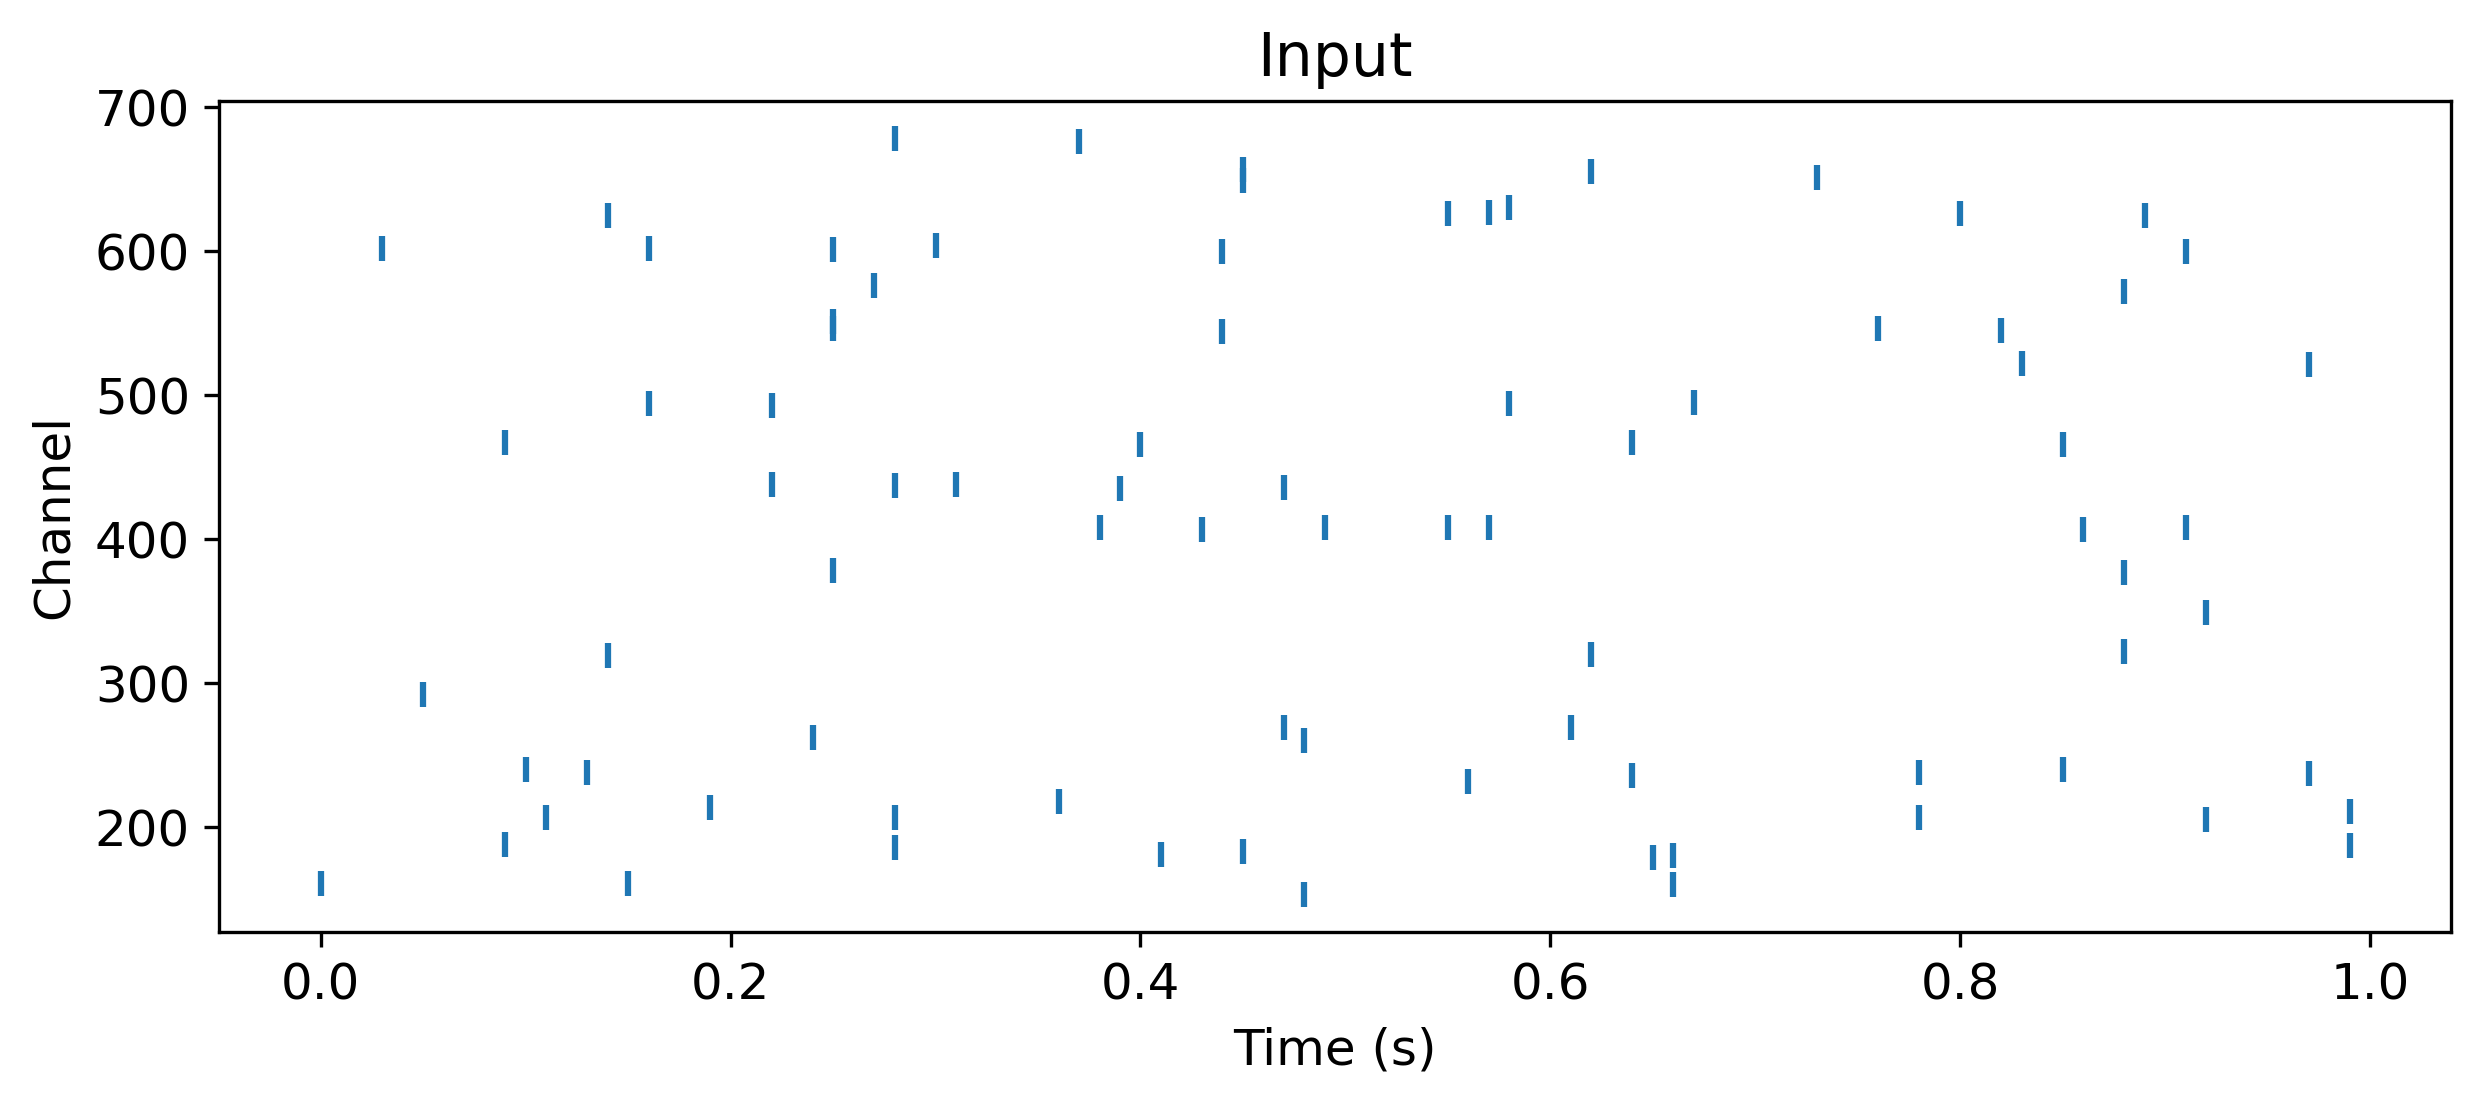

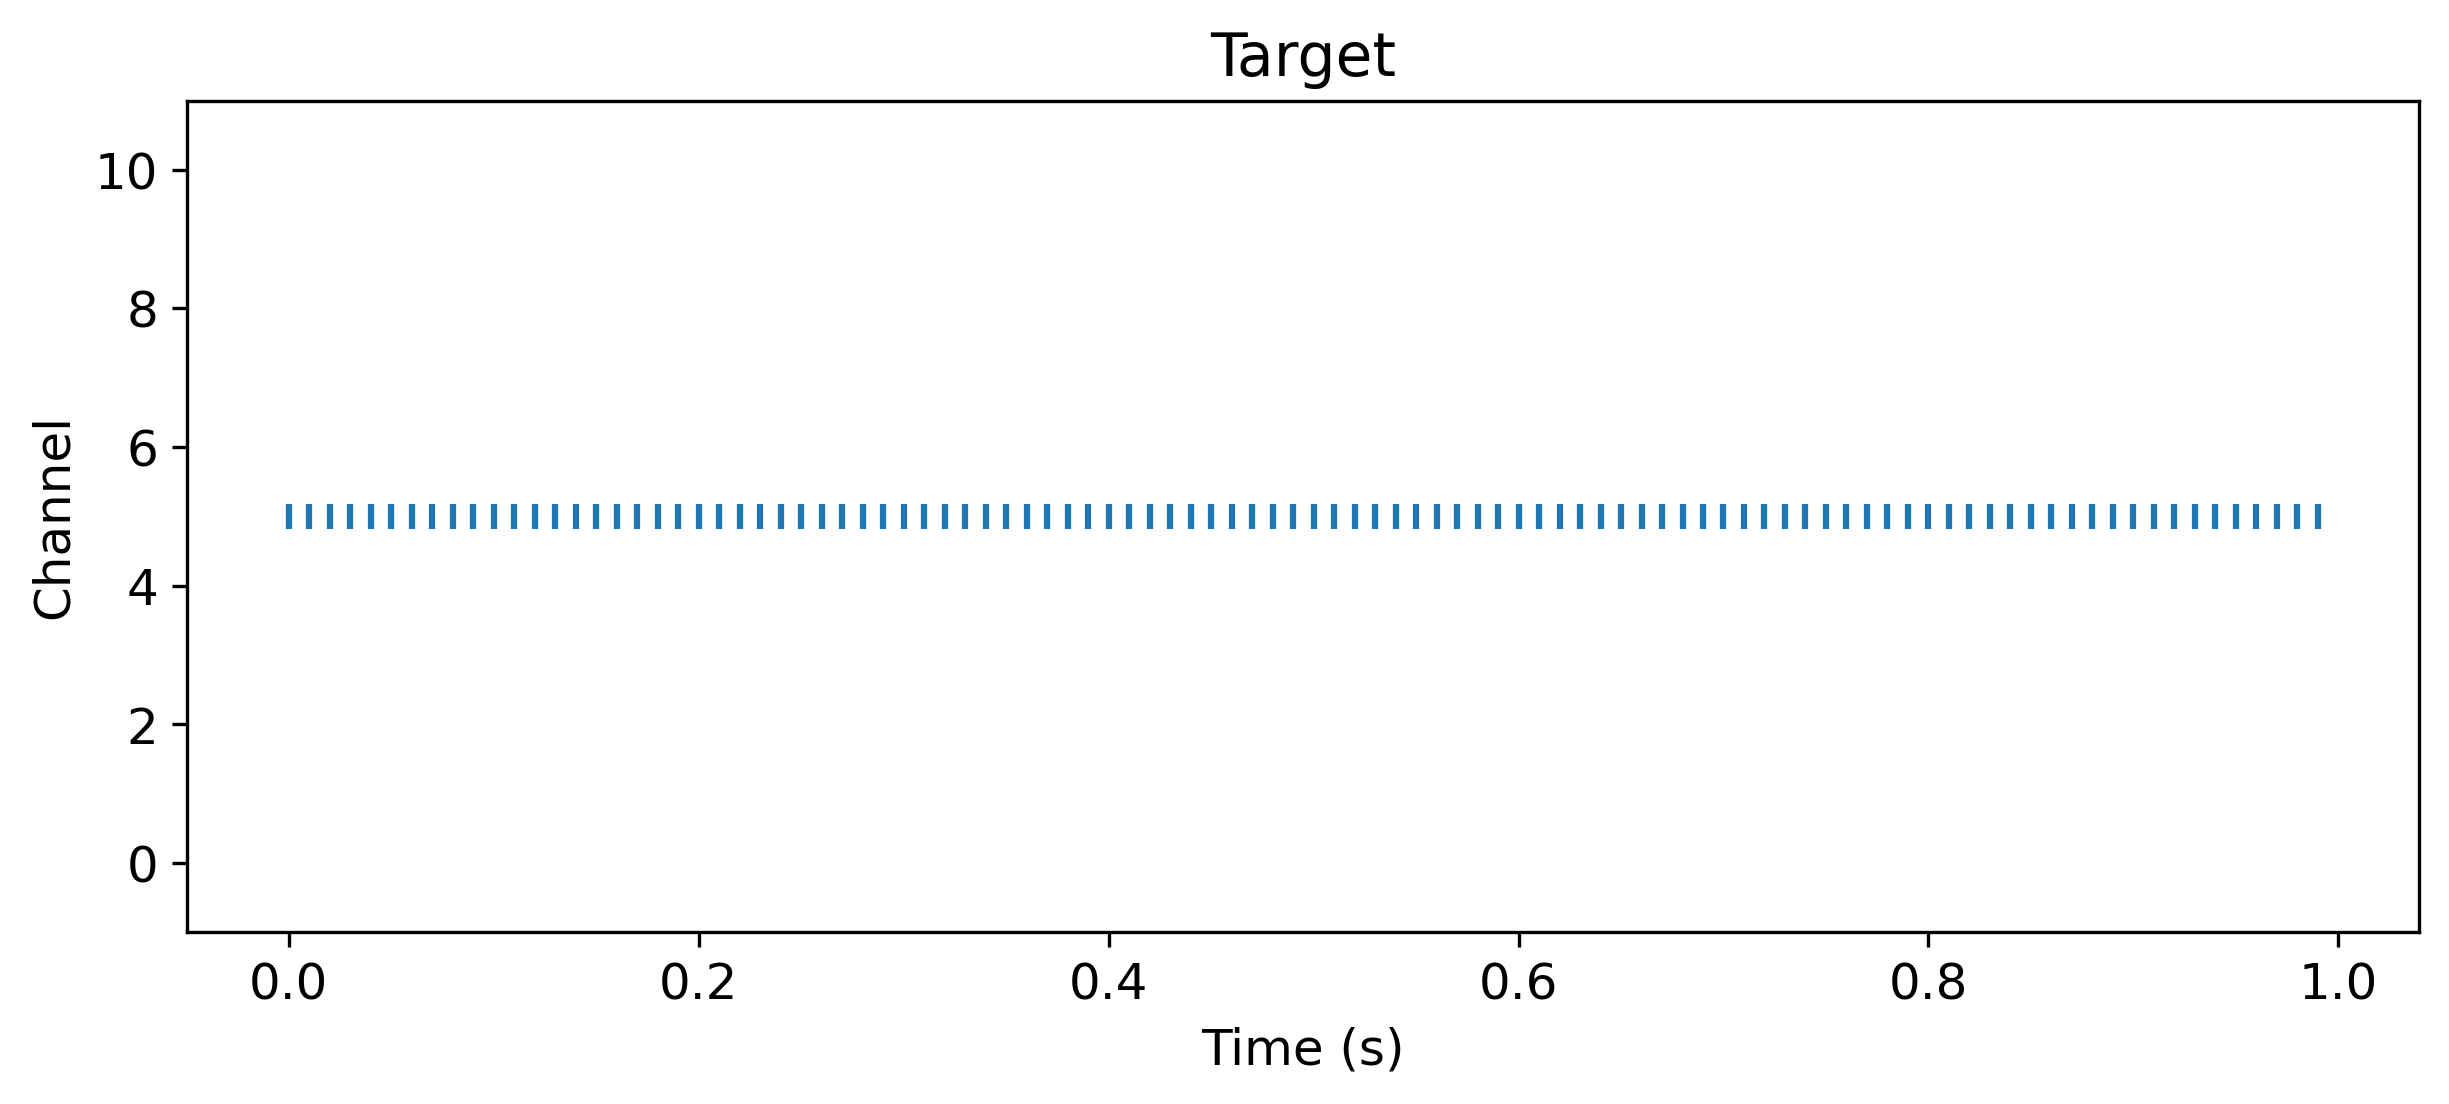

In [11]:
# - Get one sample
frame, class_idx = train_data[0]

# - Encode the input and targets
data = encode_poisson(frame, num_timesteps)
target = encode_class(torch.tensor(class_idx), num_classes, num_timesteps)

# - Plot the poisson input for this sample
plt.figure()
b, t, n = torch.nonzero(data, as_tuple = True)
plt.scatter(t * dt, n, marker = '|')
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.title('Input')

# - Plot the target event series for this sample
b, t, n = torch.nonzero(target, as_tuple = True)
plt.figure()
plt.scatter(t * dt, n, marker = '|')
plt.ylim([-1, num_classes+1])
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.title('Target');




Rockpool allows you to build SNNs with a simple syntax, similar to PyTorch. We support several computational back-ends in Rockpool, one of which is PyTorch, which we will use here.

LIFTorch is a Rockpool and torch module which provides a trainable simulation of LIF spiking neurons. LinearTorch is a linear weight matrix, comparable to the torch nn.Linear module.

To build simple feed-forward networks, we use the Sequential combinator from Rockpool, which functions like the torch nn.Sequential combinator.

By default, Rockpool allows you to train the time constants

and other parameters of an SNN. For simplicity, here we’ll define them as constant (i.e. non-trainable), using the Constant parameter decorator.

The network architecture we will use is shown below; a simple two-layer SNN.

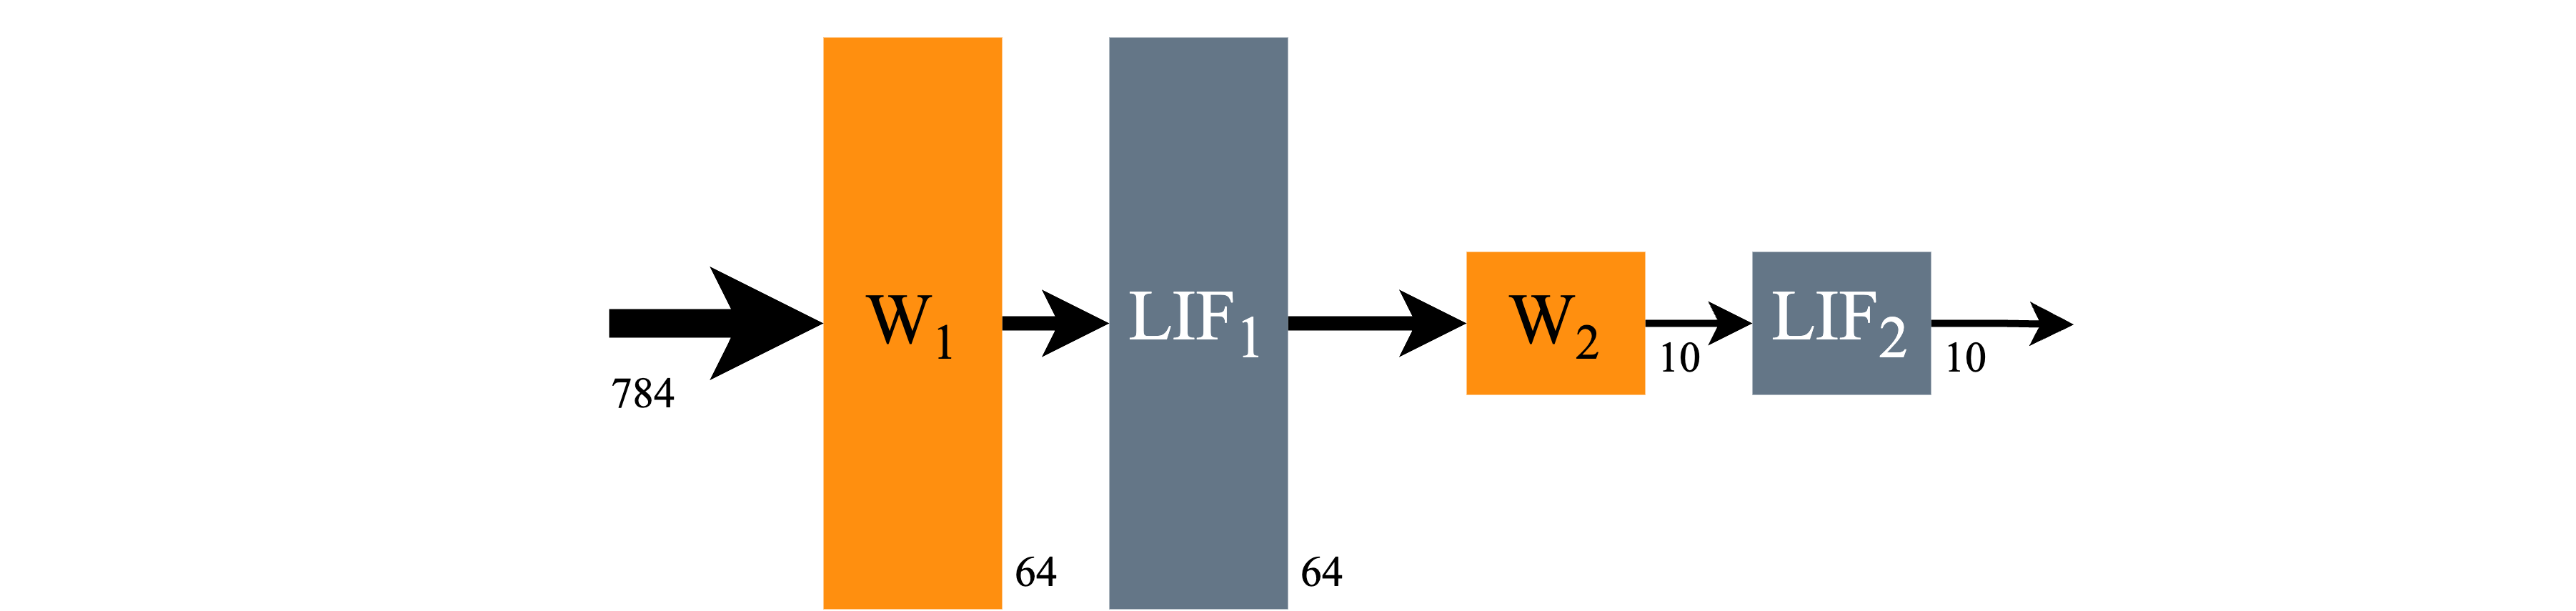

In [12]:
Image('https://www.hep.uniovi.es/vischia/persistent/figures/basics_hello_MNIST_14_0.png')

In [13]:
# - Import network packages
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant

# - Define a simple network
num_hidden = 64
tau_mem = Constant(100e-3)
tau_syn = Constant(50e-3)
threshold = Constant(1.)
bias = Constant(0.)

# - Define a two-layer feed-forward SNN
snn = Sequential(
    LinearTorch((input_channels, num_hidden)),
    LIFTorch(num_hidden, tau_syn = tau_syn, tau_mem = tau_mem, threshold = threshold, bias = bias, dt = dt),

    LinearTorch((num_hidden, num_classes)),
    LIFTorch(num_classes, tau_syn = tau_syn, tau_mem = tau_mem, threshold = threshold, bias = bias, dt = dt)
)
print(snn)

TorchSequential  with shape (784, 10) {
    LinearTorch '0_LinearTorch' with shape (784, 64)
    LIFTorch '1_LIFTorch' with shape (64, 64)
    LinearTorch '2_LinearTorch' with shape (64, 10)
    LIFTorch '3_LIFTorch' with shape (10, 10)
}


# Untrained SNN

Let’s examine the un-trained output of this network. We simulate the network identically as with the single LIF neuron above, just by passing input data to the module. We’ll use the single data sample we encoded above. The record = True argument tells Rockpool to record all the internal state of the SNN during evolution.


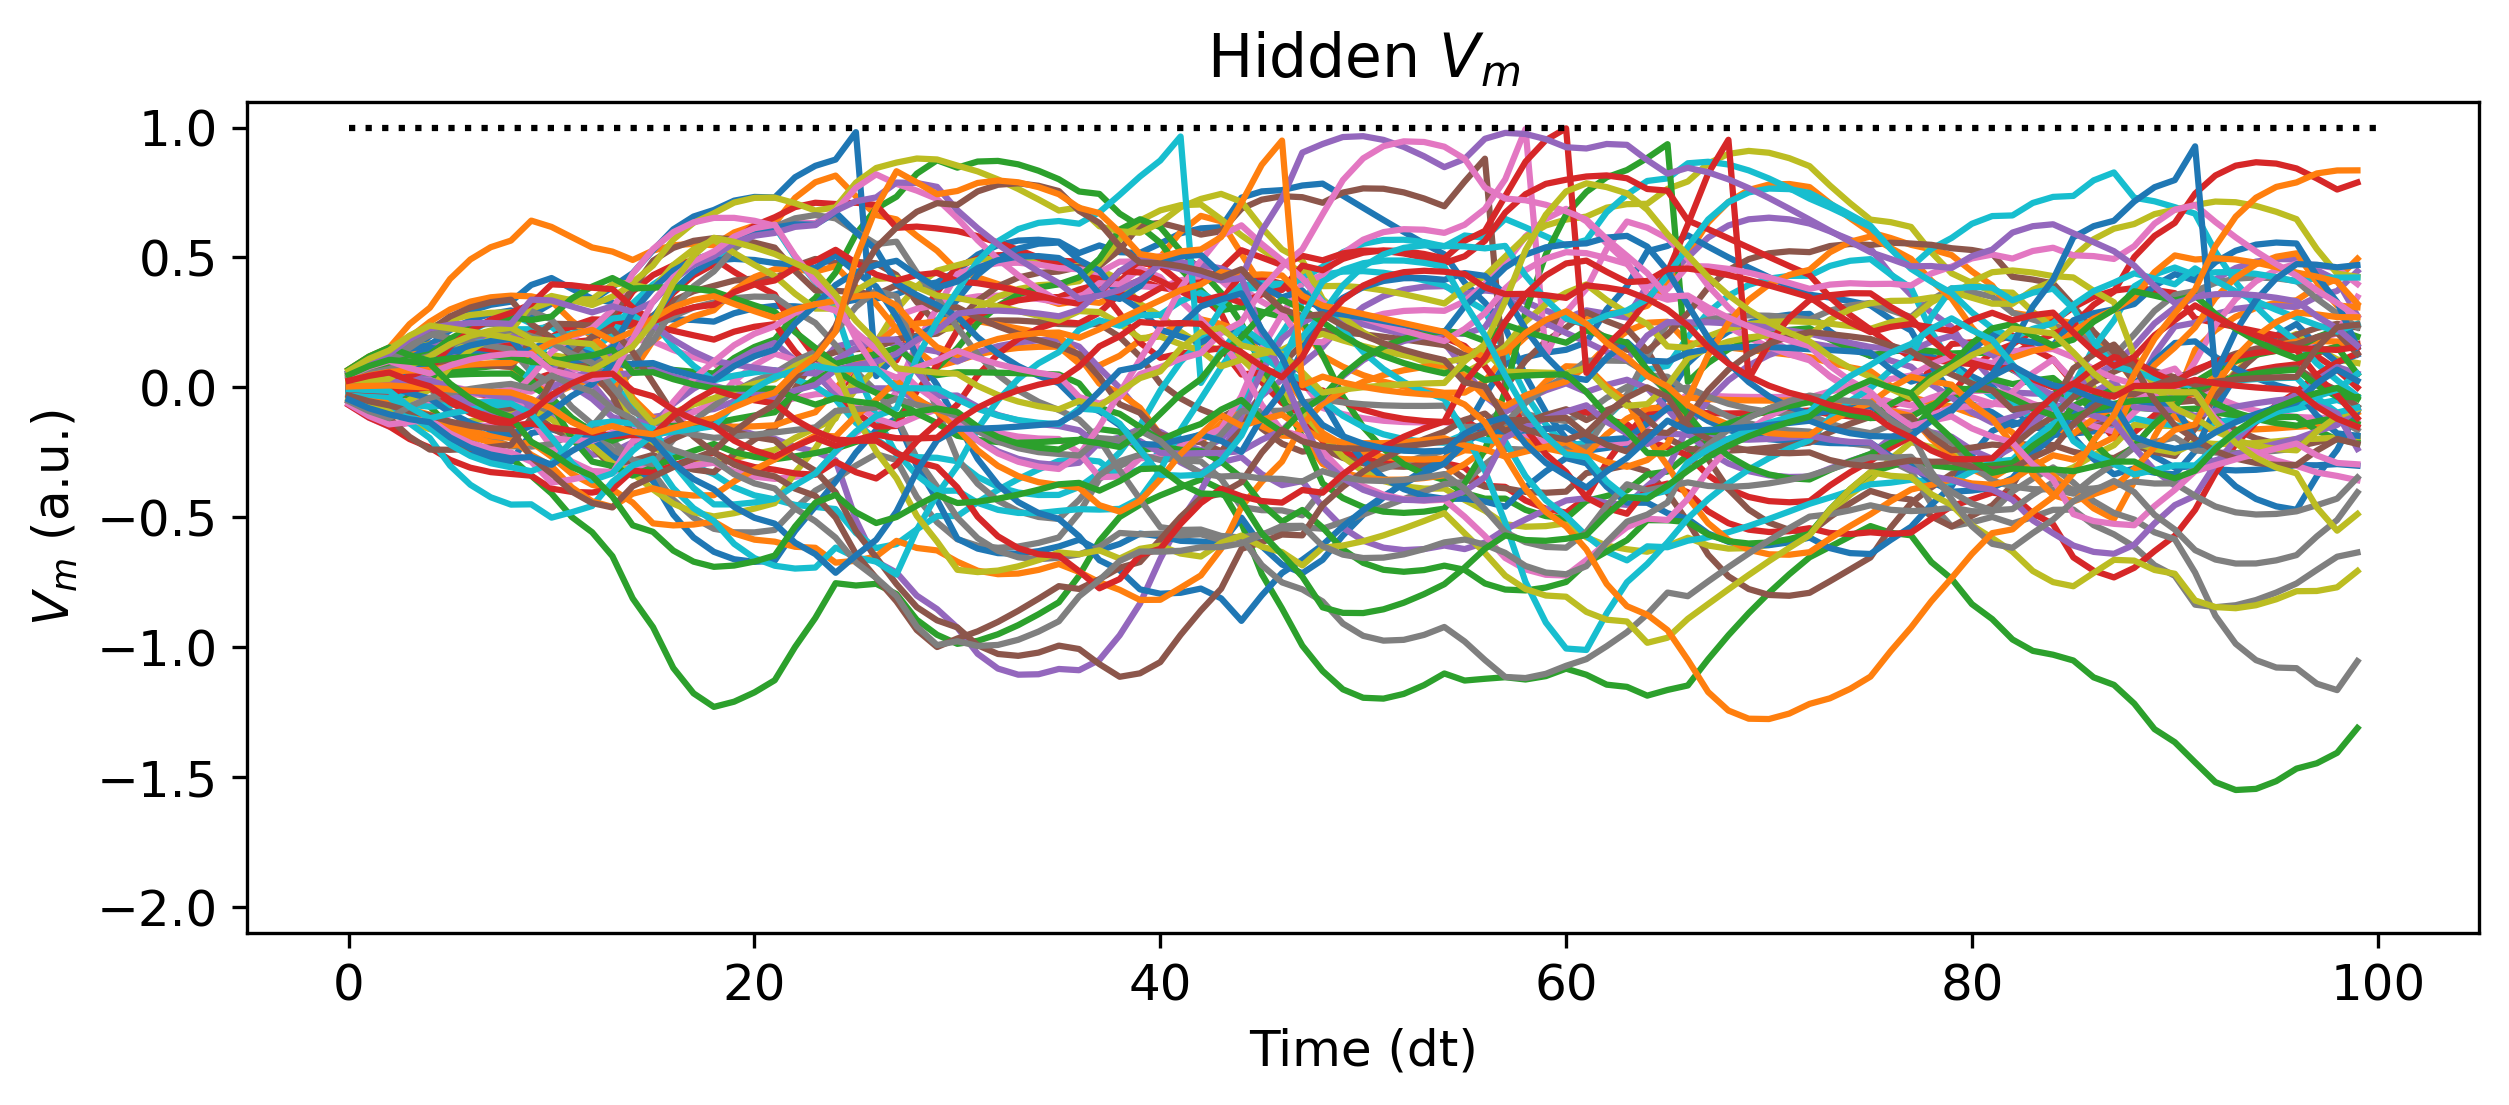

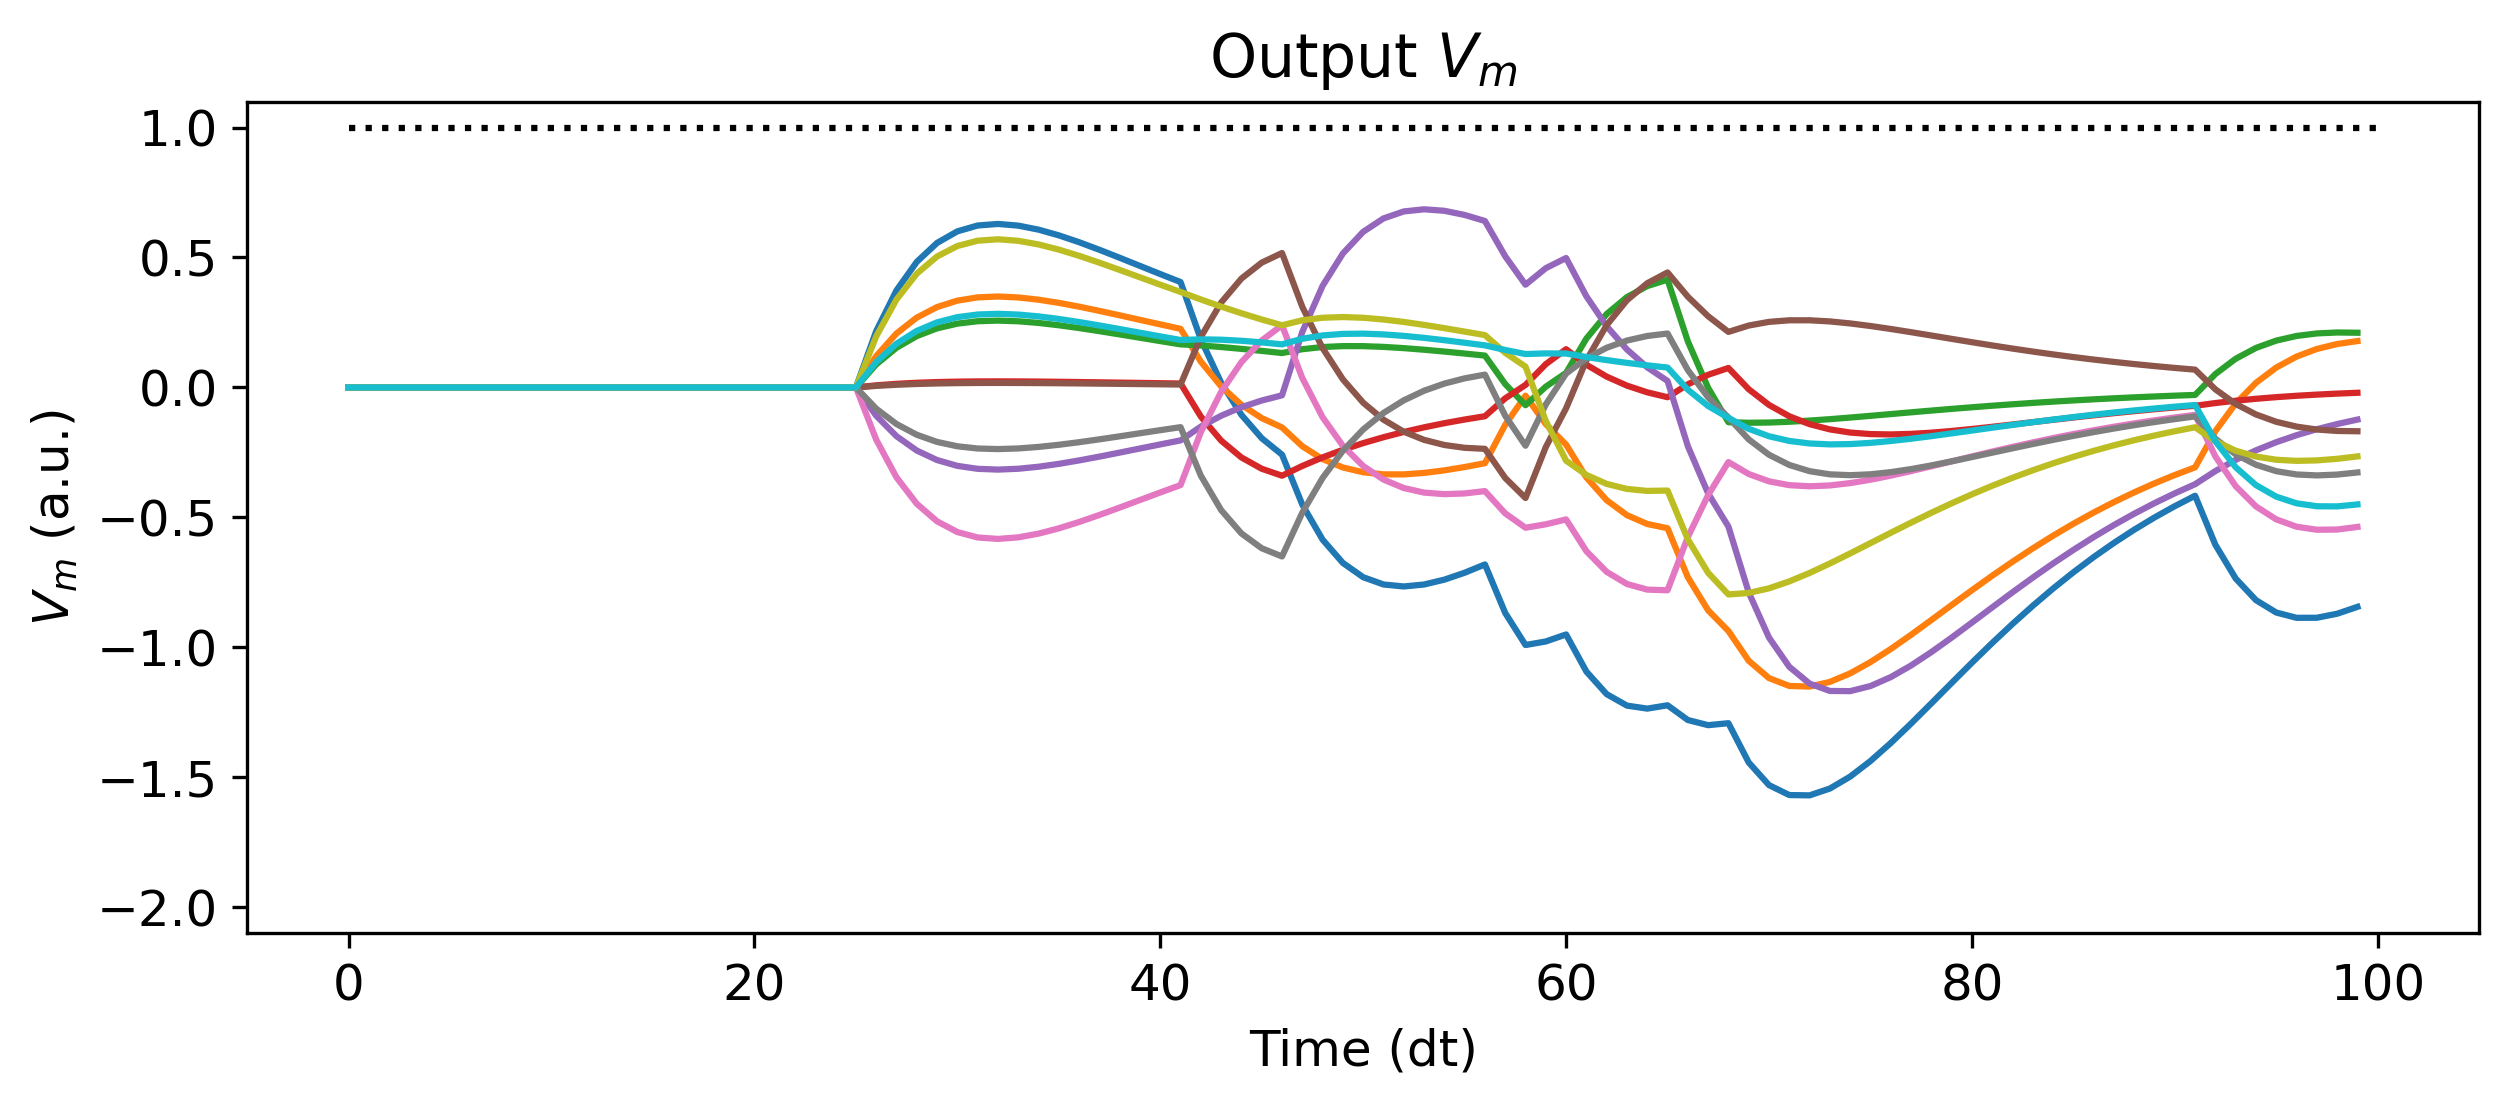

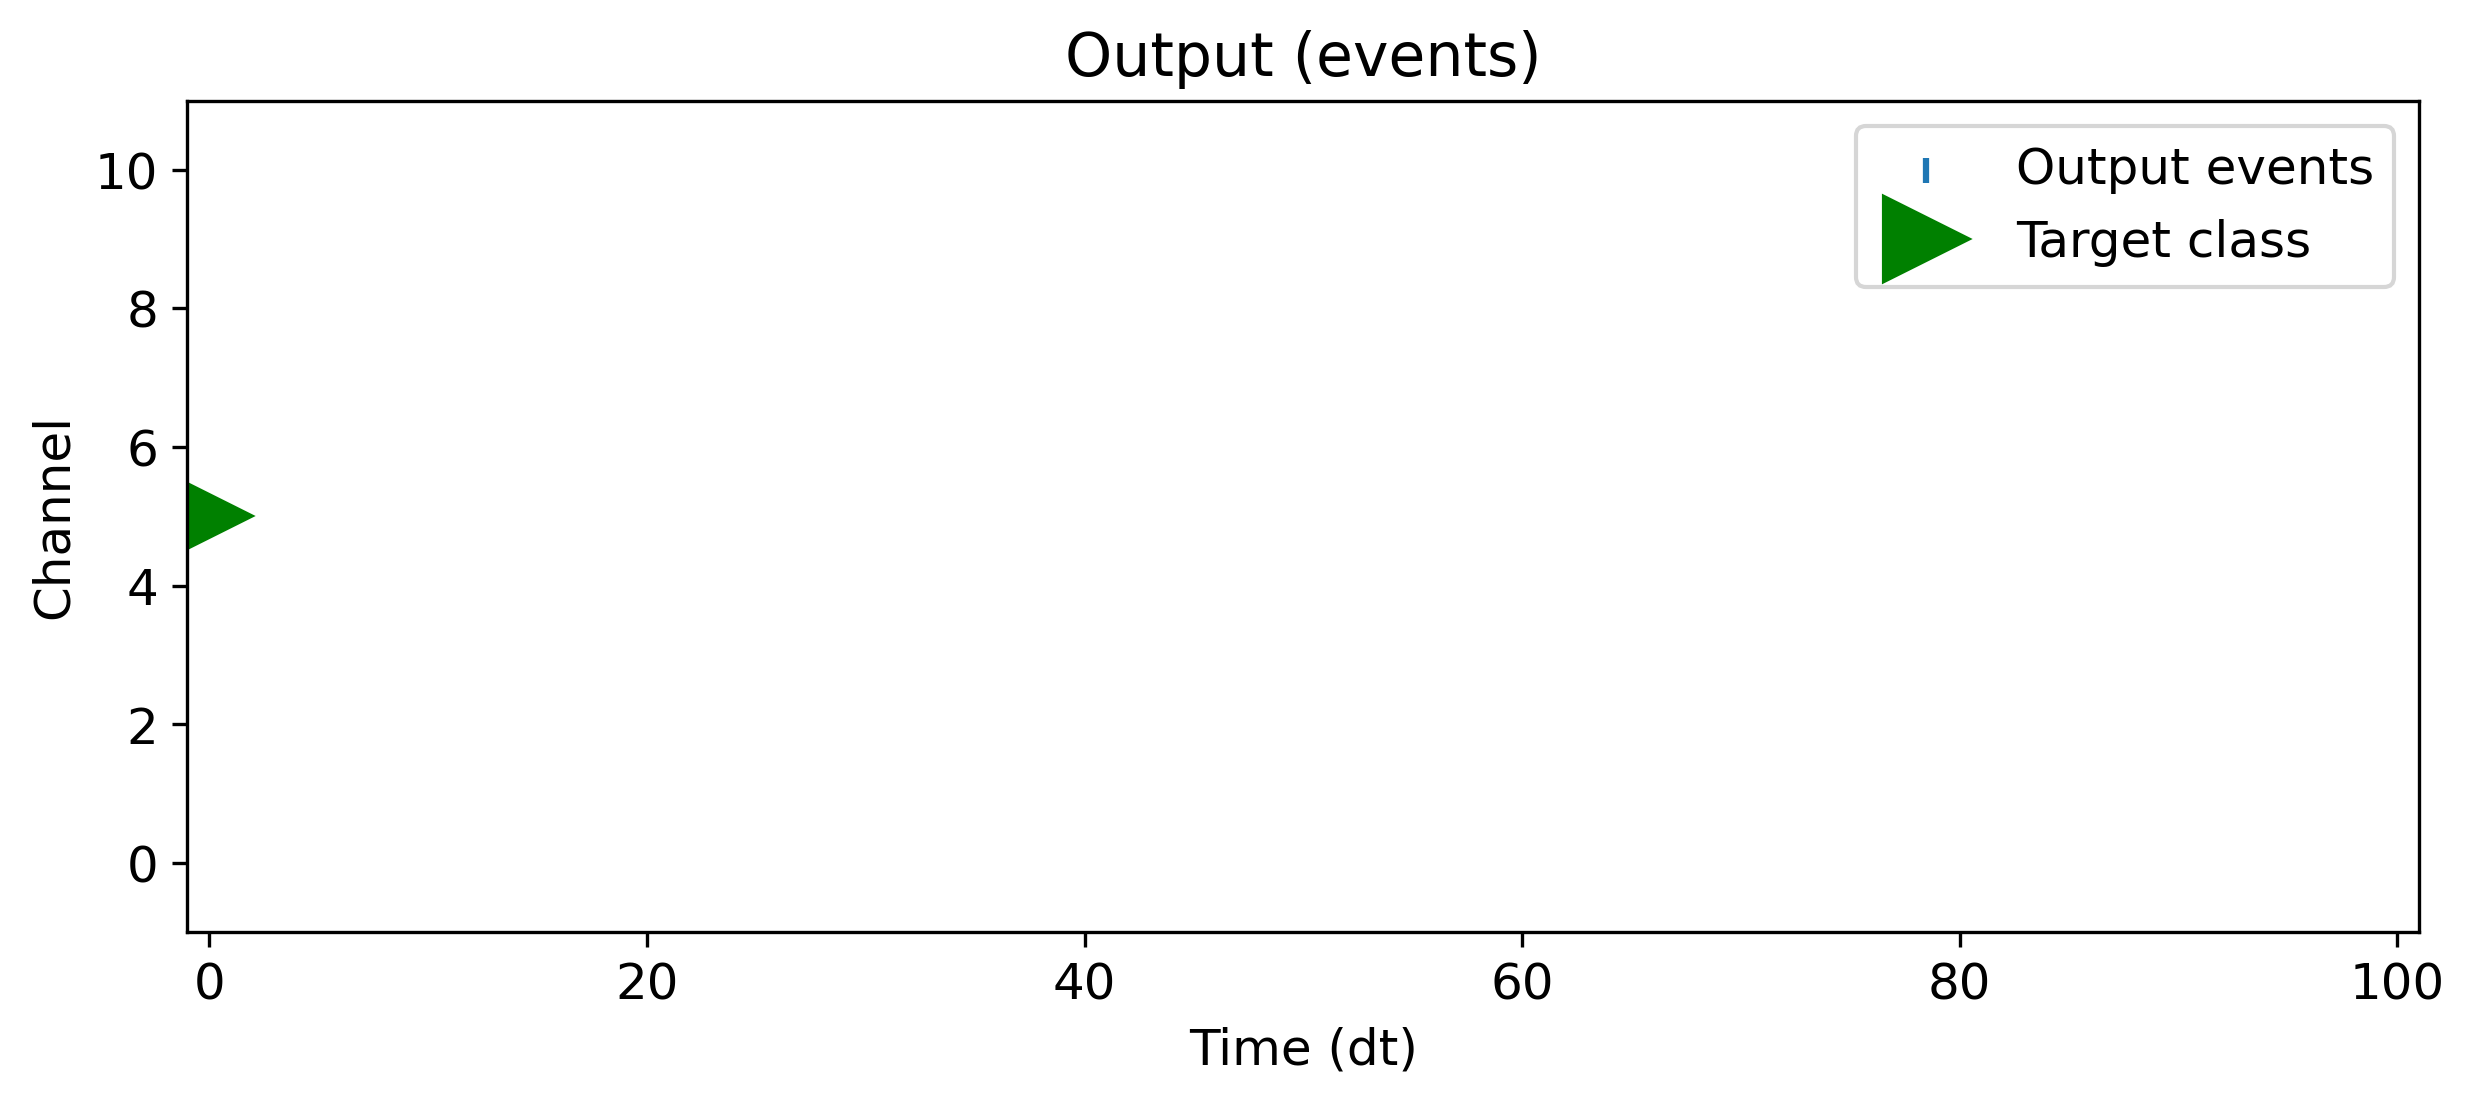

In [14]:
# - Simulate the untrained network, record internal state
output, _, rec_dict = snn(data, record = True)

# - Display the internal state and output
plt.plot(rec_dict['1_LIFTorch']['vmem'][0].detach());
plt.plot([0, num_timesteps], [threshold] * 2, 'k:')
plt.ylim([-2.1, 1.1])
plt.xlabel('Time (dt)')
plt.ylabel('$V_m$ (a.u.)')
plt.title('Hidden $V_m$')

plt.figure()
plt.plot(rec_dict['3_LIFTorch']['vmem'][0].detach());
plt.plot([0, num_timesteps], [threshold] * 2, 'k:')
plt.ylim([-2.1, 1.1])
plt.xlabel('Time (dt)')
plt.ylabel('$V_m$ (a.u.)')
plt.title('Output $V_m$')

plt.figure()
t, n = torch.nonzero(rec_dict['3_LIFTorch_output'][0].detach(), as_tuple = True)
plt.scatter(t, n, marker = '|', label='Output events')
plt.plot(0, class_idx, 'g>', markersize=20, label='Target class')
plt.ylim([-1, num_classes+1])
plt.xlim([-1, num_timesteps+1])
plt.xlabel('Time (dt)')
plt.ylabel('Channel')
plt.title('Output (events)')
plt.legend();



In [15]:
from torch.optim.adam import Adam

# - Initialise the optimizer with the network parameters
optimizer = Adam(snn.parameters().astorch())

In [16]:
# - Determine which advice to use for training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [17]:
def neuromorphic_train(model, device, train_loader, optimizer):
  # - Prepare model for training
  model.train()
  losses = []

  # - Loop over the dataset for this epoch
  for data, class_idx in tqdm(train_loader, leave=False, desc='Training', unit='batch'):
    # - Encode input and target
    data = encode_poisson(data.squeeze(), num_timesteps)
    target = encode_class(class_idx, num_classes, num_timesteps)

    # - Zero gradients, simulate model
    optimizer.zero_grad()
    output, _, _ = model(data.to(device))

    # - Compute MSE loss and perform backward pass
    loss = torch.nn.functional.mse_loss(output, target.to(device))
    loss.backward()
    optimizer.step()

    # - Keep track of the losses
    losses.append(loss.item())

  return losses

In [18]:
def neuromorphic_test(model, device, test_loader):
    # - Prepare model for evaluation
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      # - Loop over the dataset
      for data, class_idx in tqdm(test_loader, desc='Testing', leave=False, unit='batch'):
        # - Encode the input and target
        input = encode_poisson(data.squeeze(), num_timesteps)
        target = encode_class(class_idx, num_classes, num_timesteps)

        # - Evaluate the model
        output, _, _ = model(input.to(device))

        # - Compute loss and prediction
        test_loss += torch.nn.functional.mse_loss(output, target.to(device)).item()
        pred = output.sum(axis = 1).argmax(axis = 1, keepdim=True).cpu()
        correct += pred.eq(class_idx.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [19]:
# - Initial loss and accuracy
test_loss, test_acc = neuromorphic_test(snn.to(device), device, test_loader)
print(f'Initial test loss {test_loss}, accuracy {test_acc}%')

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Initial test loss 0.00042596796452999116, accuracy 7.19%


Training:   0%|          | 0/3 [00:00<?, ?epoch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

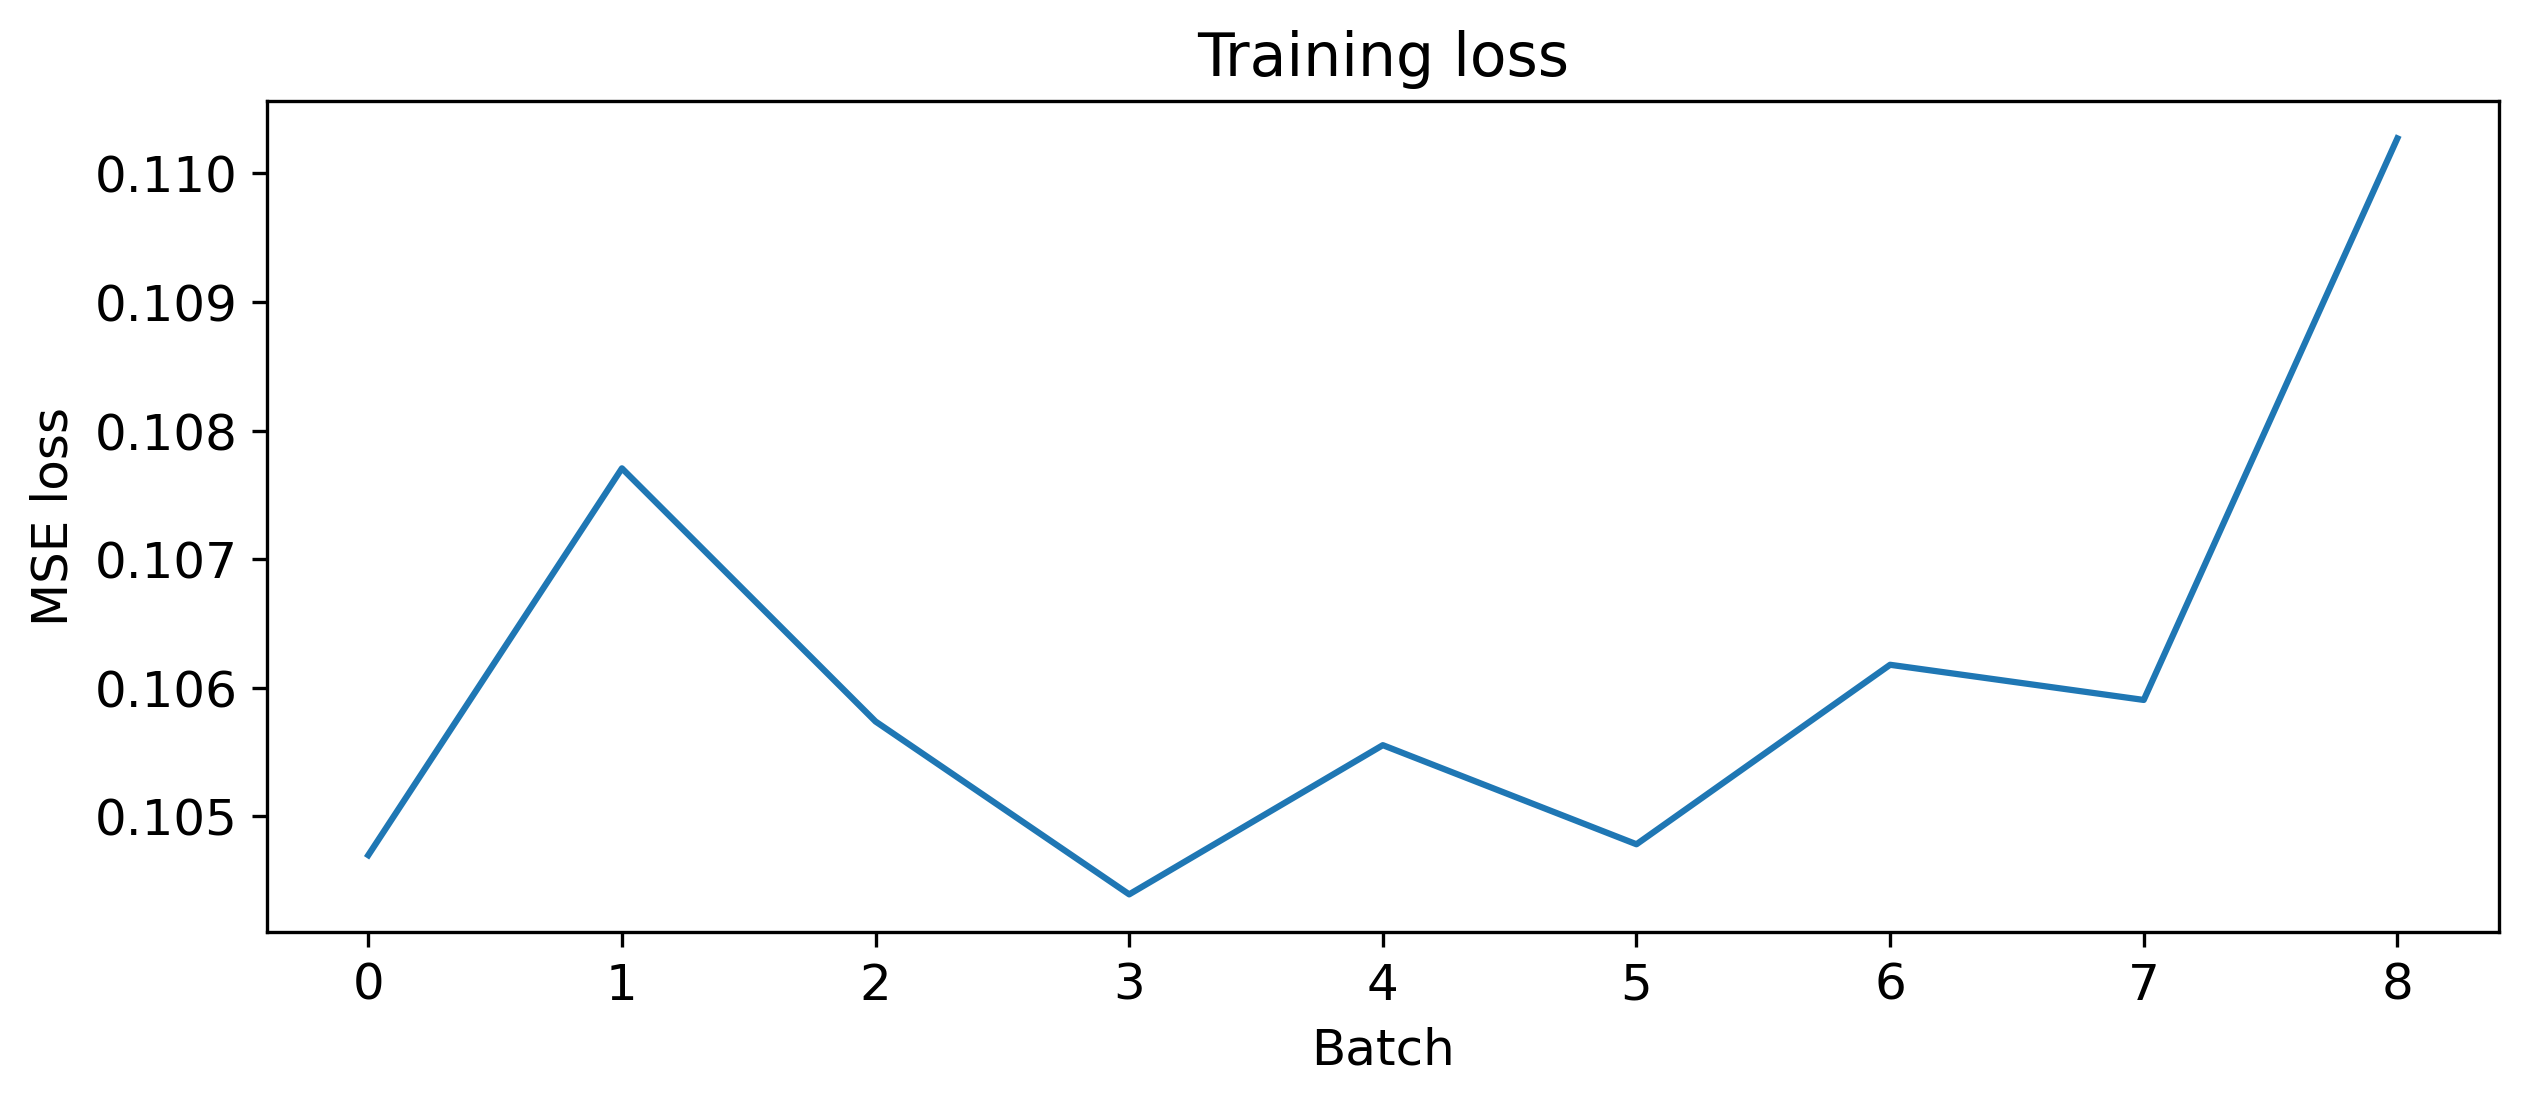

In [20]:
# - Train some epochs
num_epochs = 3

all_losses = []
ep_loop = trange(num_epochs, desc='Training', unit='epoch')
for epoch in ep_loop:
  ep_loop.set_postfix(test_loss = test_loss, test_acc = f'{test_acc}%')
  losses = neuromorphic_train(snn.to(device), device, train_loader, optimizer)
  all_losses.extend(losses)

  # - Get test loss and accuracy
  test_loss, test_acc = neuromorphic_test(snn.to(device), device, test_loader)

plt.plot(all_losses)
plt.xlabel('Batch')
plt.ylabel('MSE loss')
plt.title('Training loss');

In [22]:
# - Trained loss and accuracy
print(f'Final test loss {test_loss}, accuracy {test_acc}%')
neuro_accuracy = test_acc

Final test loss 0.0004390269510447979, accuracy 16.1%


On a single image

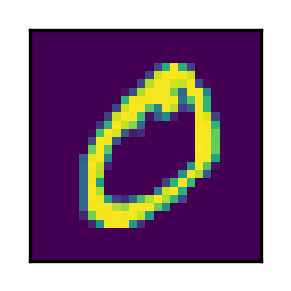

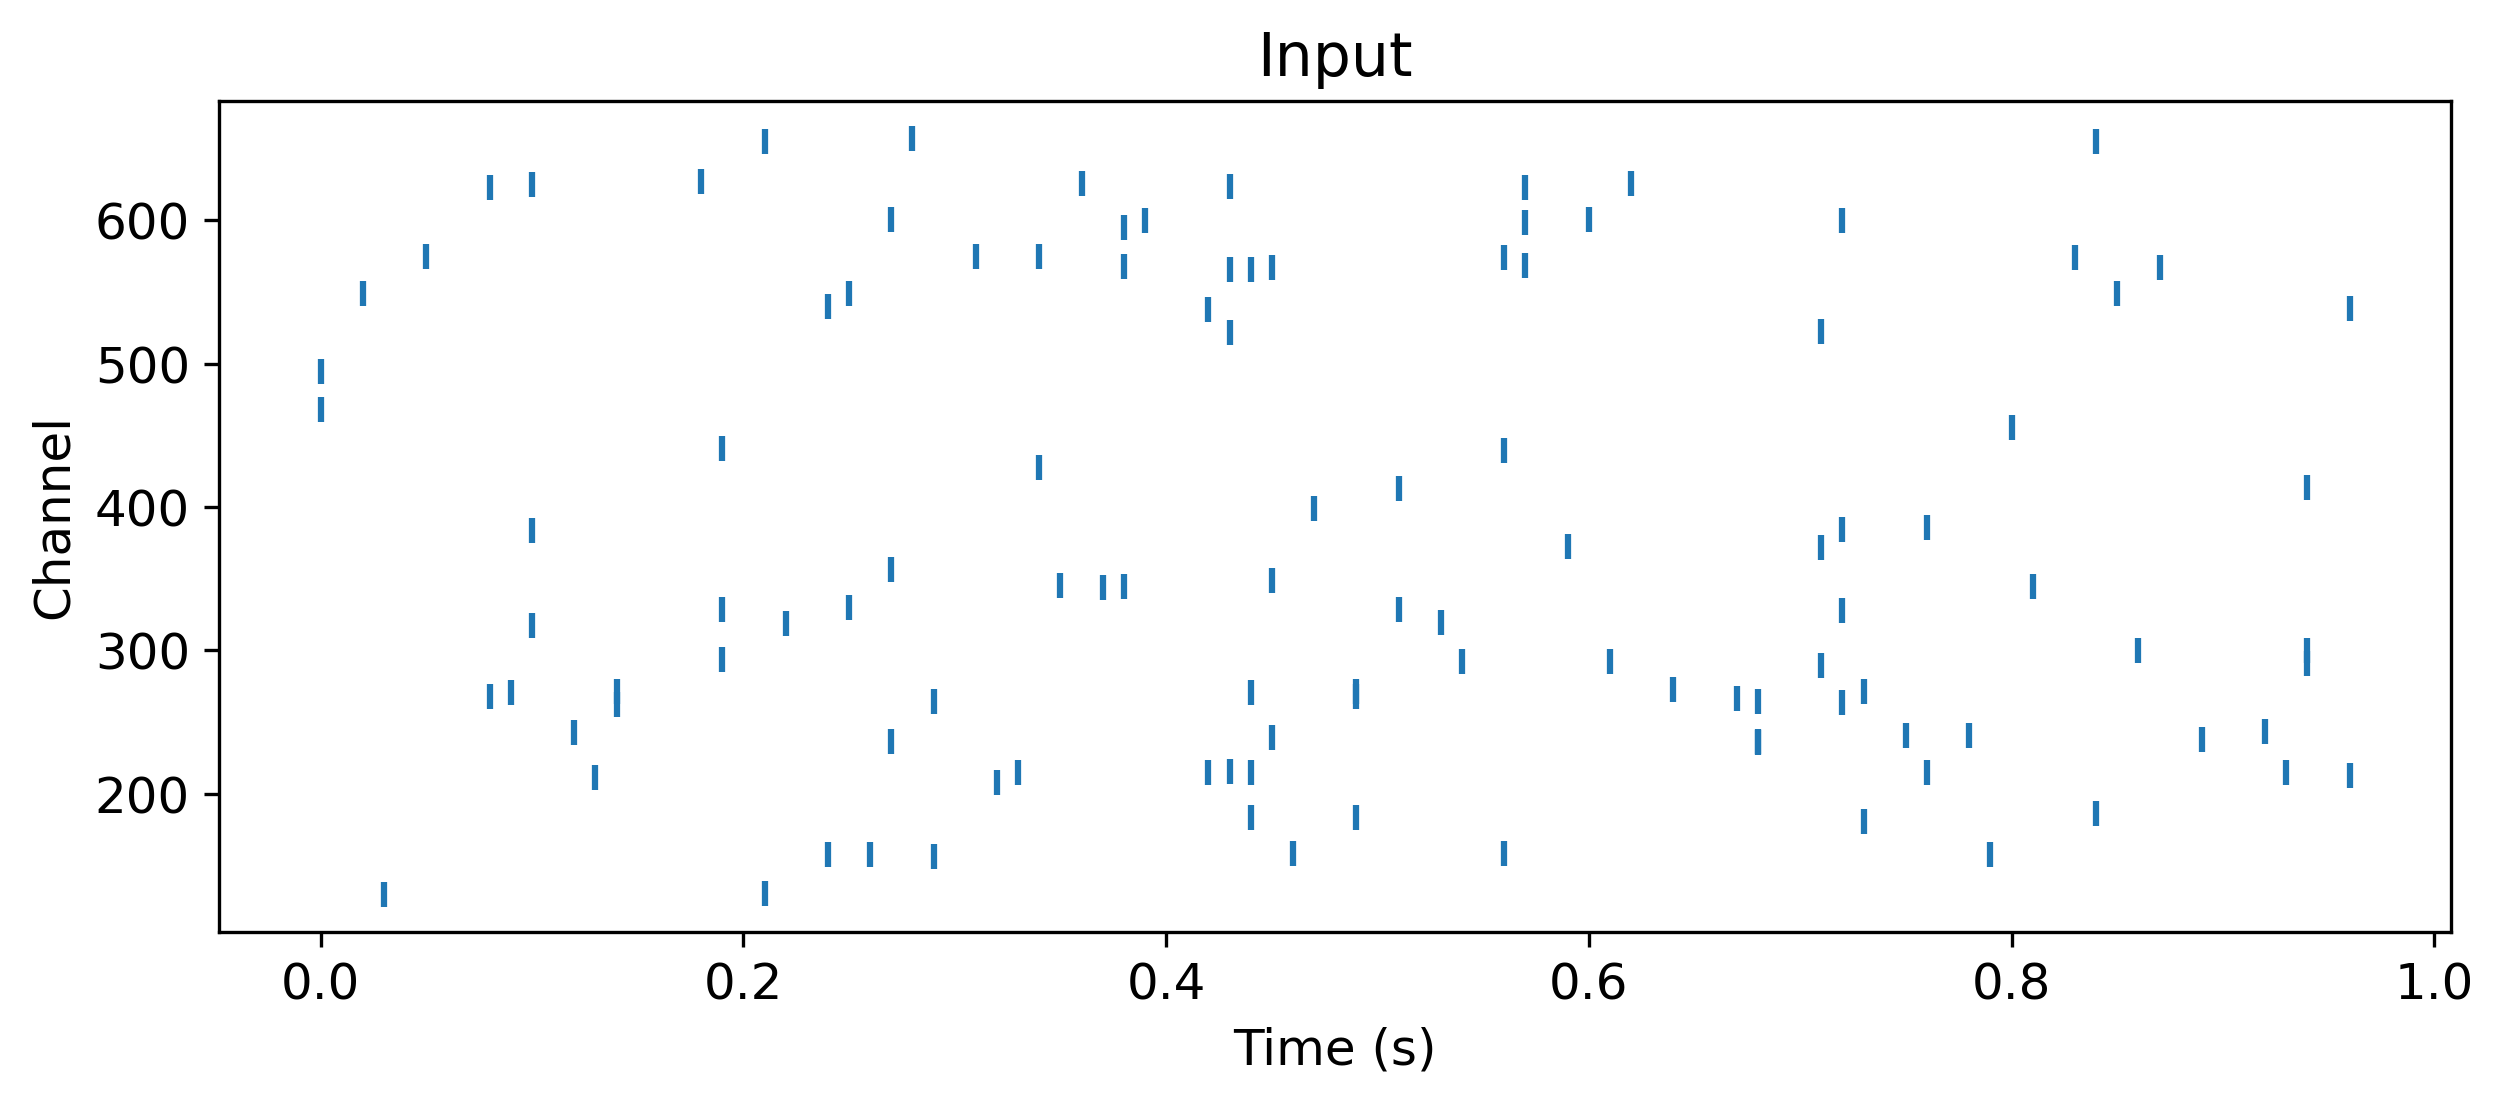

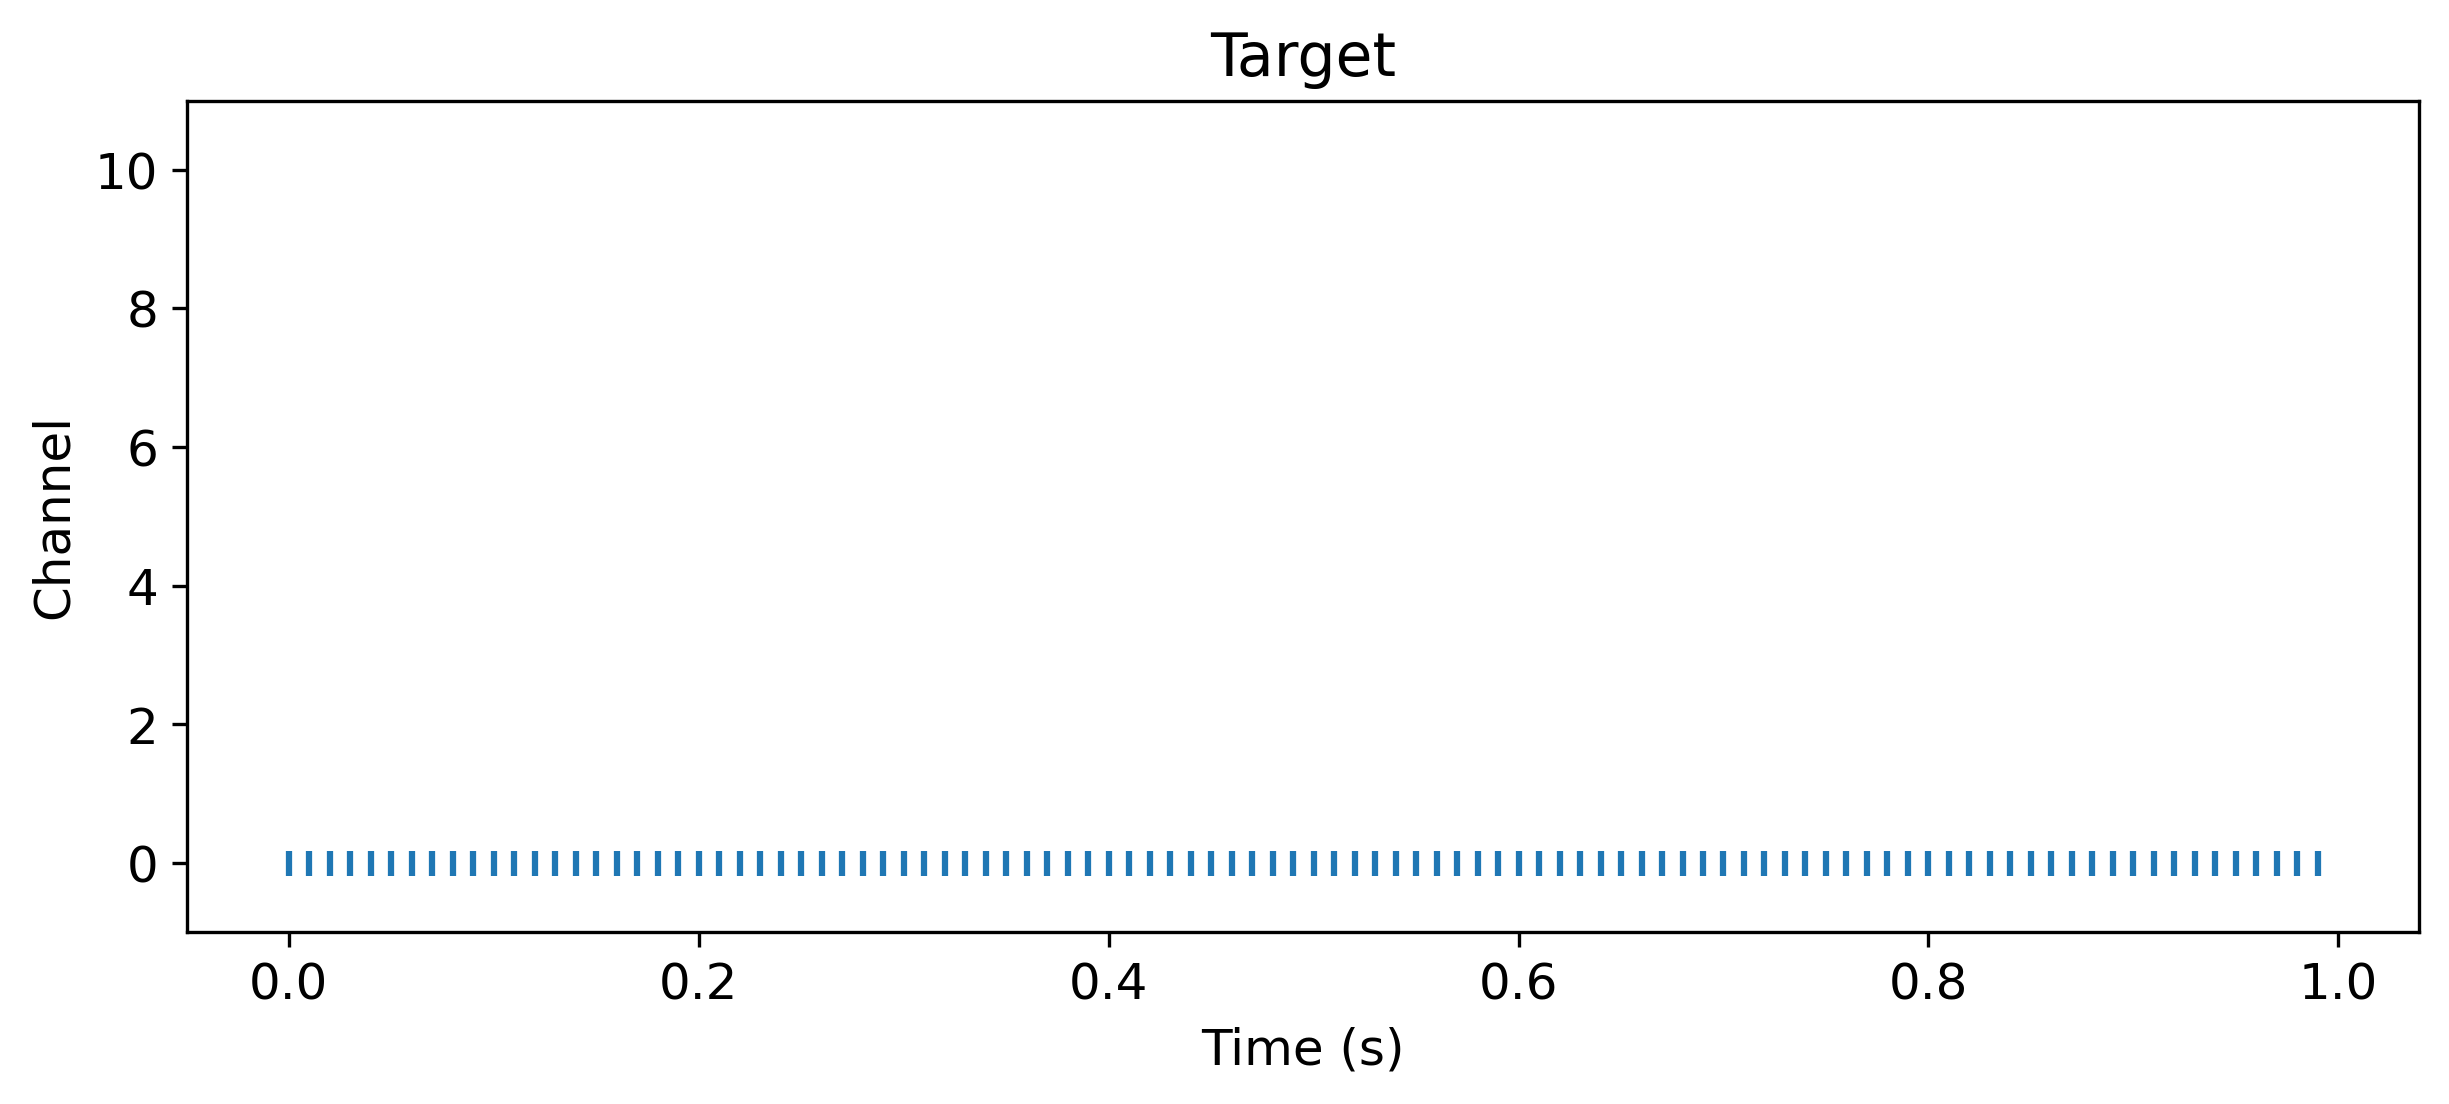

In [23]:
# - Pull a single test sample and display it
frame, class_idx = train_data[1]
data = encode_poisson(frame, num_timesteps)
target = encode_class(torch.tensor(class_idx), num_classes, num_timesteps)

plt.figure(figsize=(1, 1))
plt.imshow(frame[0])
plt.xticks([])
plt.yticks([])

plt.figure()
b, t, n = torch.nonzero(data, as_tuple = True)
plt.scatter(t * dt, n, marker='|')
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.title('Input')

b, t, n = torch.nonzero(target, as_tuple = True)
plt.figure()
plt.scatter(t * dt, n, marker='|')
plt.ylim([-1, num_classes+1])
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.title('Target');

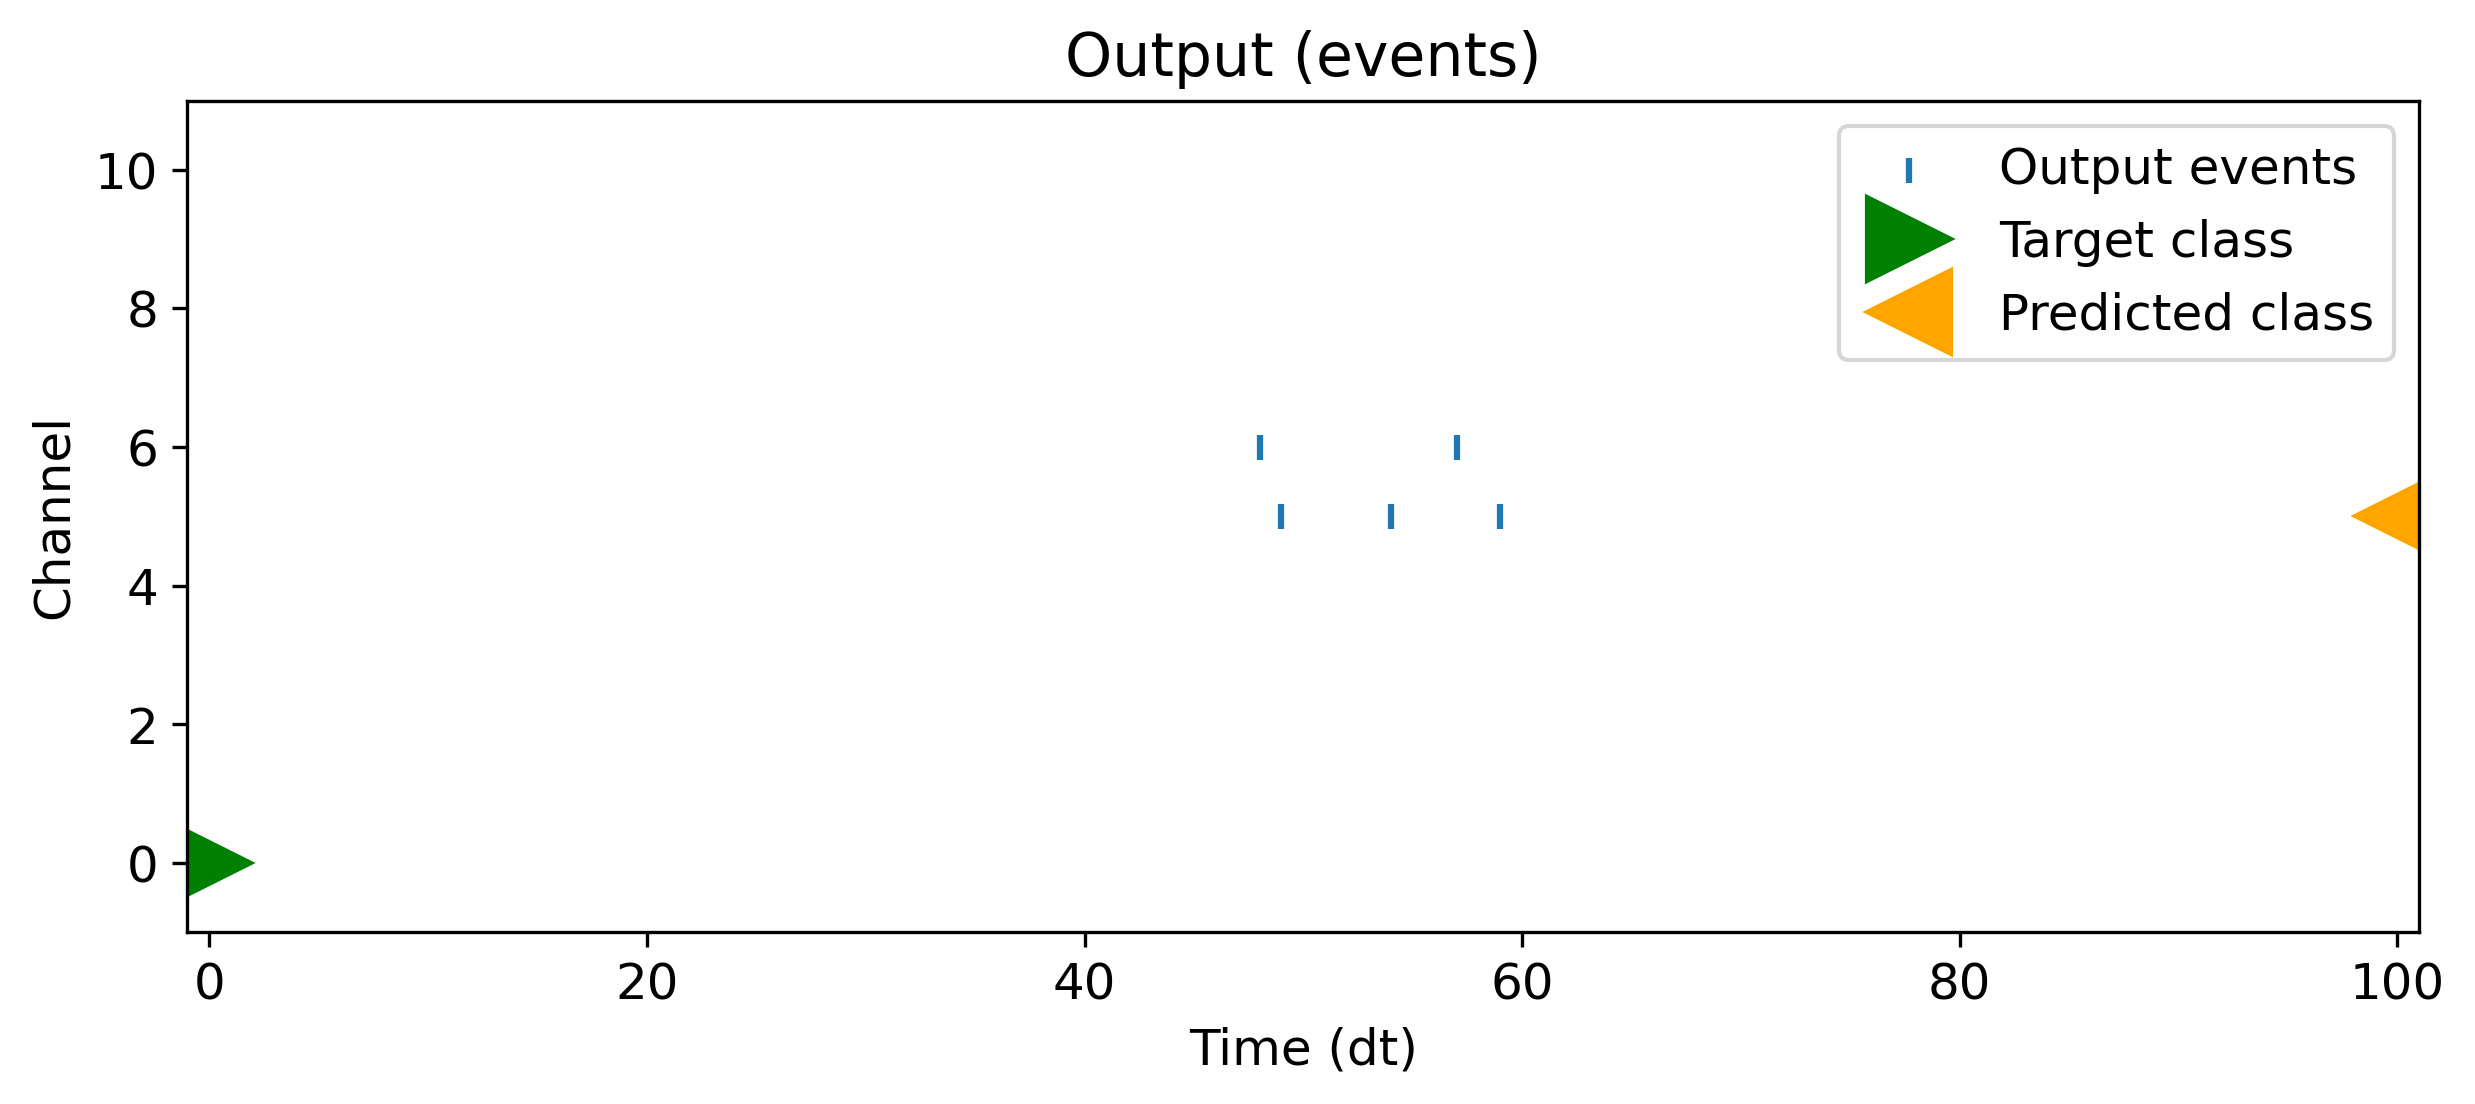

In [24]:
# - Simulate the network with this sample
output, _, _ = snn.cpu()(data)
pred = output.sum(axis = 1).argmax(axis = 1, keepdim=True).cpu()

# - Display the network output
b, t, n = torch.nonzero(output, as_tuple=True)

plt.scatter(t, n, marker='|', label='Output events')
plt.plot(0, class_idx, 'g>', markersize=20, label='Target class')
plt.plot(100, pred, '<', c='orange', markersize=20, label='Predicted class')
plt.ylim([-1, num_classes+1])
plt.xlim([-1, num_timesteps+1])
plt.xlabel('Time (dt)')
plt.ylabel('Channel')
plt.title('Output (events)')
plt.legend();



Things to consider for full trainings

- Deeper or more complex network architecture
- More hidden neurons
- Training time constants and other parameters
- Different loss function or output encoding

# Quantum machine learning

We will also work with the MNIST dataset to classify handwritten digits. At the end, we will compare the two approaches.


In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


Will use the MNIST dataset in the same way as https://arxiv.org/abs/1802.06002

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))


11490434/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


In [3]:
# Filter the dataset to keep just the 3s and 6s, remove the other classes. At the same time convert the label, y, to boolean: True for 3 and False for 6.

def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))


Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


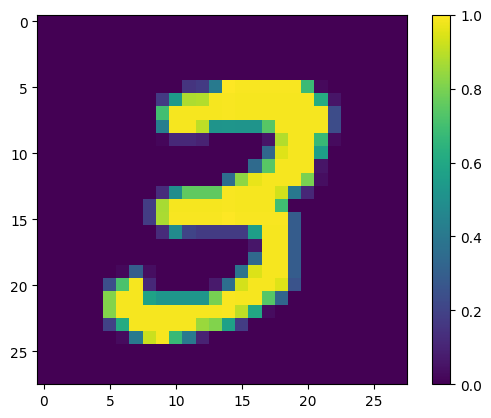

In [4]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()


An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

True


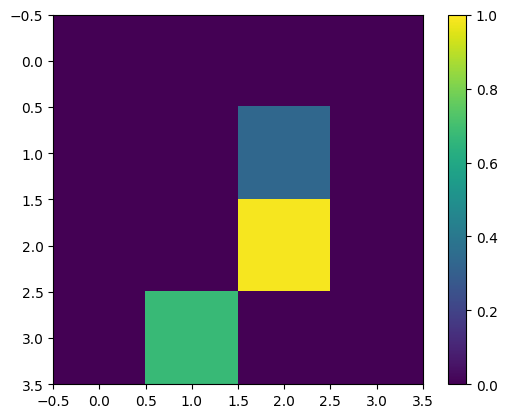

In [5]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()


In [6]:
# Remove samples that are labelled as belonging to both classes
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)


In [7]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)


Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


# Quantum encoding

Represent each pixel as a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.



In [8]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)


In [9]:
# The qubits at pixel indices with values that exceed a threshold, are rotated through an gate.

def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]


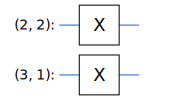

In [10]:
SVGCircuit(x_train_circ[0])
# warning: circuit diagrams do not show qubits with zero gates


In [11]:
# Compare this circuit to the indices where the image value exceeds the threshold:

bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

In [12]:
# Convert circuits to tensors (to handle them with tensorflow)
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)


There is little guidance for a quantum circuit structure that classifies images. Since the classification is based on the expectation of the readout qubit, Farhi et al. propose using two qubit gates, with the readout qubit always acted upon. This is similar in some ways to running small a Unitary RNN across the pixels.
2.1 Build the model circuit

This following example shows this layered approach. Each layer uses n instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit:

In [13]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)


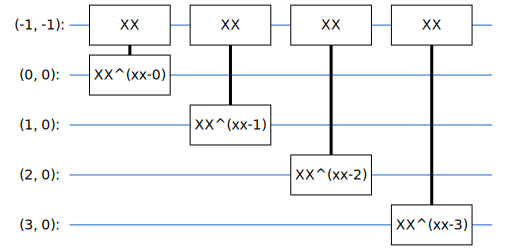

In [14]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)


In [15]:
# Now for real

def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)


In [16]:
model_circuit, model_readout = create_quantum_model()


Build the Keras model with the quantum components. This model is fed the "quantum data", from x_train_circ, that encodes the classical data. It uses a Parametrized Quantum Circuit layer, tfq.layers.PQC, to train the model circuit, on the quantum data.

To classify these images, Farhi et al. proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [17]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])


# Since the the expected readout is in the range [-1,1], optimizing the hinge loss is a somewhat natural fit.

In [18]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0


In [19]:
def hinge_accuracy(y_true, y_pred): # correctly handles hinge loss
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)


In [20]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 32        
                                                                 
Total params: 32 (128.00 Byte)
Trainable params: 32 (128.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [21]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = 200  # or, for 45 minutes training, len(x_train_tfcirc)


In [22]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]


In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)


# Classical model

While the quantum neural network works for this simplified MNIST problem, a basic classical neural network can easily outperform a QNN on this task. After a single epoch, a classical neural network can achieve >98% accuracy on the holdout set.

In the following example, a classical neural network is used for for the 3-6 classification problem using the entire 28x28 image instead of subsampling the image. This easily converges to nearly 100% accuracy of the test set.

In [ ]:
def create_classical_model():
    # A simple model (1.2M params) based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()



In [ ]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)


In [ ]:
def create_fair_classical_model():
    # A simpler (37 params) model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()


In [ ]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)


In [ ]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(x=["Quantum", "Classical, full", "Classical, fair", "Neuromorphic"],
            y=[qnn_accuracy, cnn_accuracy, fair_nn_accuracy, neuro_accuracy])
